# Universidad de los Andes
## Maestría en Inteligencia Analítica para la Toma de Decisiones
## Final Project - Deep Learning and Neural Networks

### Camilo Torres Ovalle, Código 201743423
### Wilfredo Vega Buelvas, Código 201723430

#### Below is the procedure and the code used to:
Create a solution using both images and text with a Machine Learning algorithm

Create a solution using both images and text with a Deep Learning algorithm (CNN, transfer learning, RNN)

In [241]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline

# Read Data

In [2]:
path = '../finalProject/'

In [3]:
dataTraining = pd.read_csv(os.path.join(path, 'data', 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'data', 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [4]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [6]:
dataTraining['genres'].value_counts()

['Drama']                                                            429
['Comedy']                                                           368
['Comedy', 'Drama', 'Romance']                                       306
['Comedy', 'Romance']                                                291
['Comedy', 'Drama']                                                  287
['Drama', 'Romance']                                                 282
['Documentary']                                                      154
['Crime', 'Drama', 'Thriller']                                       125
['Drama', 'Thriller']                                                115
['Horror']                                                           115
['Horror', 'Thriller']                                               108
['Action', 'Crime', 'Drama', 'Thriller']                             102
['Crime', 'Drama']                                                    88
['Comedy', 'Crime']                                

# Read Images

In [7]:
image = io.imread(os.path.join(path, 'images_resize_gray', str(dataTraining.index[0]) + '_resize_gray.jpeg'))

In [8]:
image

array([[ 3,  3,  3, ..., 57, 55, 51],
       [ 3,  3,  3, ..., 99, 98, 95],
       [ 3,  3,  3, ..., 97, 96, 94],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

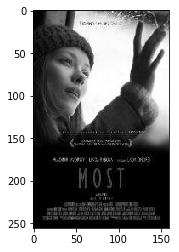

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

## Read all images

In [10]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

100%|██████████| 7895/7895 [00:09<00:00, 835.20it/s]


In [11]:
images_training = np.stack(images_training)

images_training.shape, dataTraining.shape[0]

((7895, 40960), 7895)

In [12]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]

100%|██████████| 3383/3383 [00:03<00:00, 892.04it/s]


((3383, 40960), 3383)

In [13]:
images_testing

array([[195, 192, 190, ...,  66,  72,  81],
       [ 28,  28,  27, ...,  17,  17,  16],
       [  0,   0,   0, ...,   3,   3,   2],
       ...,
       [255, 250, 249, ..., 236, 255, 255],
       [ 86,  82,  75, ...,  29,  45,  40],
       [ 94,  54,  60, ...,  64,  57,  95]], dtype=uint8)

## Apply PCA

In [14]:
pca = PCA(n_components=32)
images_training_pca = pca.fit_transform(images_training)

In [15]:
images_testing_pca = pca.transform(images_testing)

# Create y

In [16]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [17]:
y_genres.shape

(7895, 24)

In [56]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training_pca, y_genres, test_size=0.33, random_state=42)

In [57]:
X_train.shape

(5289, 32)

In [58]:
X_test.shape

(2606, 32)

In [59]:
y_train_genres.shape

(5289, 24)

In [60]:
y_test_genres.shape

(2606, 24)

# Train multi-class multi-label model Random Forest

In [61]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=1, n_estimators=200, max_depth=10, random_state=32,bootstrap=True, class_weight="balanced"))

In [62]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=32, verbose=0, warm_start=False),
          n_jobs=1)

In [63]:
y_pred_genres = clf.predict_proba(X_test)

In [64]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.610802775240662

# Apply models to test

In [24]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(images_testing_pca)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')

## preprocessing before the build the models

In [20]:
from keras.applications import VGG16
from skimage.transform import resize
vgg16 = VGG16(include_top=False, weights='imagenet')

Using TensorFlow backend.


58892288/58889256 [==============================] - ETA: 10:0 - ETA: 6:2 - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 56 - ETA: 54 - ETA: 52 - ETA: 52 - ETA: 50 - ETA: 48 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA

In [176]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Reshape image_training

In [31]:
def apply_vgg_grayscale(images):

    images_ = []
    for img in tqdm(images):

        # reshape
        img = img.reshape((256, 160))

        # rescale
        img = resize(img, (224, 224), mode='reflect')

        # repeat
        img = [img] * 3

        images_.append(img)
        
          # To numpy array
    images_ = np.array(images_)

    # move channel to last axis
    images_ = np.rollaxis(images_, 1, 4)

    # Apply vgg
    images_vgg = vgg16.predict(images_)
    
    return images_vgg

images_training_vgg = apply_vgg_grayscale(images_training)
images_training_vgg.shape

100%|██████████| 7895/7895 [00:28<00:00, 273.38it/s]


(7895, 7, 7, 512)

### Reshape image_testing

In [30]:
def apply_vgg_grayscale(images):

    images_ = []
    for img in tqdm(images):

        # reshape
        img = img.reshape((256, 160))

        # rescale
        img = resize(img, (224, 224), mode='reflect')

        # repeat
        img = [img] * 3

        images_.append(img)
        
          # To numpy array
    images_ = np.array(images_)

    # move channel to last axis
    images_ = np.rollaxis(images_, 1, 4)

    # Apply vgg
    images_vgg = vgg16.predict(images_)
    
    return images_vgg

images_testing_vgg = apply_vgg_grayscale(images_testing)
images_testing_vgg.shape

100%|██████████| 3383/3383 [00:10<00:00, 308.17it/s]


(3383, 7, 7, 512)

In [39]:
images_testing_vgg

array([[[[2.53222615e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 5.01114130e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 6.19823933e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 7.49393821e-01, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 6.43093288e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 6.31566167e-01, 0.00000000e+00],
         [1.70725346e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 7.95173645e-01, 0.00000000e+00]],

        [[5.69700360e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 6.83407128e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 8.08400989e-01, 0.00000000e+00],
        

### Split

In [93]:
#split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training_vgg, y_genres, test_size=0.2, random_state=42)

In [47]:
X_train.shape, y_train_genres.shape, X_test.shape, y_test_genres.shape

((6316, 7, 7, 512), (6316, 24), (1579, 7, 7, 512), (1579, 24))

## Convolutional Neural Network

### initialization

In [781]:
model_1 = Sequential()
model_1.add(Conv2D(512,(7,7),padding='same',activation='relu',input_shape=X_train.shape[1:]))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Flatten(input_shape =X_train.shape[1:]))
model_1.add(Dropout(0.5))
model_1.add(Dense(24, activation='sigmoid'))
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 7, 7, 512)         12845568  
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 4608)              0         
_________________________________________________________________
dense_148 (Dense)            (None, 24)                110616    
Total params: 12,956,184
Trainable params: 12,956,184
Non-trainable params: 0
_________________________________________________________________


### Compilation

In [782]:
model_1.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

### Fit

In [783]:
model_1.fit(X_train, y_train_genres, epochs=20, verbose=2)

Epoch 1/20
 - 321s - loss: 11.6222 - acc: 0.1626
Epoch 2/20
 - 323s - loss: 13.5232 - acc: 0.1645
Epoch 3/20
 - 313s - loss: 14.4071 - acc: 0.1645
Epoch 4/20
 - 350s - loss: 13.6675 - acc: 0.1662
Epoch 5/20
 - 343s - loss: 13.6658 - acc: 0.1648
Epoch 6/20
 - 356s - loss: 13.7254 - acc: 0.1786
Epoch 7/20
 - 356s - loss: 13.6169 - acc: 0.1681
Epoch 8/20
 - 357s - loss: 13.7212 - acc: 0.1767
Epoch 9/20
 - 381s - loss: 13.6974 - acc: 0.1686
Epoch 10/20
 - 361s - loss: 13.6816 - acc: 0.1865
Epoch 11/20
 - 348s - loss: 13.6572 - acc: 0.2093
Epoch 12/20
 - 378s - loss: 13.6754 - acc: 0.1875
Epoch 13/20
 - 387s - loss: 13.7339 - acc: 0.2125
Epoch 14/20
 - 408s - loss: 13.7009 - acc: 0.2454
Epoch 15/20
 - 407s - loss: 13.1767 - acc: 0.2568
Epoch 16/20
 - 407s - loss: 7.5797 - acc: 0.2071
Epoch 17/20
 - 402s - loss: 7.3513 - acc: 0.2087
Epoch 18/20
 - 399s - loss: 7.2314 - acc: 0.2161
Epoch 19/20
 - 324s - loss: 7.1561 - acc: 0.2293
Epoch 20/20
 - 276s - loss: 7.1067 - acc: 0.2388


### prediction

In [784]:
y_pred_genres = model_1.predict_proba(X_test)

### Curve ROC

In [785]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.6631780608219592

### The ROC curve of the CNN implementation: 0.66317

### Apply models to test

In [149]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model_1.predict_proba(images_testing_vgg)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_CNN.csv', index_label='ID')

# Transfer Learning

### Below is the process and the model used to transfer learning

In [205]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten #imput de flatten de 32 x 32
from keras.layers import Conv1D, Conv2D, MaxPooling2D
from livelossplot import PlotLossesKeras

### initialization

In [229]:
model_2 = Sequential()
model_2.add(Flatten(input_shape=images_training_vgg.shape[1:]))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Dense(24, activation='sigmoid'))

model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 24)                6168      
Total params: 6,428,952
Trainable params: 6,428,952
Non-trainable params: 0
_________________________________________________________________


### Compilation

In [216]:
Opt_Nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

In [230]:
model_2.compile(loss='categorical_crossentropy',
              optimizer="Nadam",
              metrics=['accuracy'])

### Fit

In [231]:
model_2.fit(X_train, y_train_genres, epochs=20, verbose=2)

Epoch 1/20
 - 33s - loss: 8.6509 - acc: 0.1579
Epoch 2/20
 - 32s - loss: 8.4659 - acc: 0.1439
Epoch 3/20
 - 33s - loss: 7.8982 - acc: 0.1887
Epoch 4/20
 - 33s - loss: 7.5103 - acc: 0.2323
Epoch 5/20
 - 32s - loss: 7.4113 - acc: 0.2307
Epoch 6/20
 - 33s - loss: 7.3214 - acc: 0.2329
Epoch 7/20
 - 32s - loss: 7.1974 - acc: 0.2459
Epoch 8/20
 - 31s - loss: 7.1042 - acc: 0.2318
Epoch 9/20
 - 31s - loss: 7.0344 - acc: 0.2334
Epoch 10/20
 - 31s - loss: 6.9508 - acc: 0.2370
Epoch 11/20
 - 32s - loss: 6.8940 - acc: 0.2289
Epoch 12/20
 - 31s - loss: 6.8304 - acc: 0.2130
Epoch 13/20
 - 31s - loss: 6.7438 - acc: 0.2039
Epoch 14/20
 - 32s - loss: 6.6856 - acc: 0.2028
Epoch 15/20
 - 31s - loss: 6.6225 - acc: 0.2038
Epoch 16/20
 - 31s - loss: 6.5691 - acc: 0.2035
Epoch 17/20
 - 31s - loss: 6.5391 - acc: 0.2033
Epoch 18/20
 - 32s - loss: 6.4742 - acc: 0.2028
Epoch 19/20
 - 31s - loss: 6.6287 - acc: 0.2080
Epoch 20/20
 - 32s - loss: 6.4872 - acc: 0.2044


### Prediction

In [232]:
y_pred_genres = model_2.predict_proba(X_test)

### Curve ROC

In [233]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.6619674375176406

### The ROC curve of the CNN implementation: 0.66196


### Apply models to test

In [179]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model.predict_proba(images_testing_vgg)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_vvg.csv', index_label='ID')

# Models Predictive Text 

# Read Data

In [48]:
path = '../finalProject/'

In [235]:
dataTraining = pd.read_csv(os.path.join(path, 'data', 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'data', 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [236]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Create count vectorizer with ngrams

In [237]:
type(dataTraining)

pandas.core.frame.DataFrame

In [242]:
vect = CountVectorizer(ngram_range=(1, 4), max_features=2000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 2000)

In [128]:
print(vect.get_feature_names()[:50])

['able', 'able to', 'about', 'about the', 'about to', 'accident', 'across', 'act', 'action', 'actually', 'affair', 'after', 'after the', 'again', 'against', 'against the', 'age', 'agent', 'ago', 'alex', 'alive', 'all', 'all of', 'all the', 'alone', 'along', 'along the', 'along with', 'already', 'also', 'although', 'always', 'america', 'american', 'among', 'an', 'an old', 'and', 'and has', 'and he', 'and her', 'and his', 'and is', 'and she', 'and that', 'and the', 'and their', 'and then', 'and they', 'and when']


# Create y

In [243]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
Y_genres = le.fit_transform(dataTraining['genres'])

In [244]:
Y_genres.shape

(7895, 24)

# Split train and test

In [247]:
X_train_tx, X_test_tx, y_train_genres_tx, y_test_genres_tx = train_test_split(X_dtm, Y_genres, test_size=0.2, random_state=42)

In [248]:
X_train_tx.shape,  y_train_genres_tx.shape,X_test_tx.shape, y_test_genres_tx.shape

((6316, 2000), (6316, 24), (1579, 2000), (1579, 24))

# Train multi-class multi-label model the Random Forest

In [249]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=1, n_estimators=200, max_depth=10, random_state=32,bootstrap=True, class_weight="balanced"))

In [594]:
clf.fit(X_train_tx, y_train_genres_tx)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=32,
            verbose=0, warm_start=False),
          n_jobs=1)

In [595]:
y_pred_genres_tx = clf.predict_proba(X_test_tx)

In [596]:
roc_auc_score(y_test_genres_tx, y_pred_genres_tx, average='macro')

0.8004556292512229

### The ROC curve of the Random Forest implementation: 0.80045


# Apply models to kaggle test

In [253]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres_tx = clf.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres_tx, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF.csv', index_label='ID')

## Neural Network

In [536]:
import keras
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from livelossplot import PlotLossesKeras
from keras.layers import Concatenate

%matplotlib inline

### initialization

In [750]:
model_tx = Sequential()
model_tx.add(Dense(512, input_shape=X_dtm.shape[1:], activation="relu"))
model_tx.add(BatchNormalization())
model_tx.add(Dropout(0.69))
model_tx.add(Dense(24, activation='sigmoid'))
model_tx.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 512)               1024512   
_________________________________________________________________
batch_normalization_52 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_77 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 24)                12312     
Total params: 1,038,872
Trainable params: 1,037,848
Non-trainable params: 1,024
_________________________________________________________________


## Compilation

#### We call the Adam optimizer to adjust the parameters

In [751]:
op_adam = keras.optimizers.Adam(lr=0.01, beta_1=0.99, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

In [752]:
model_tx.compile(loss='categorical_crossentropy',
              optimizer=op_adam,
              metrics=['accuracy'])

## Fit

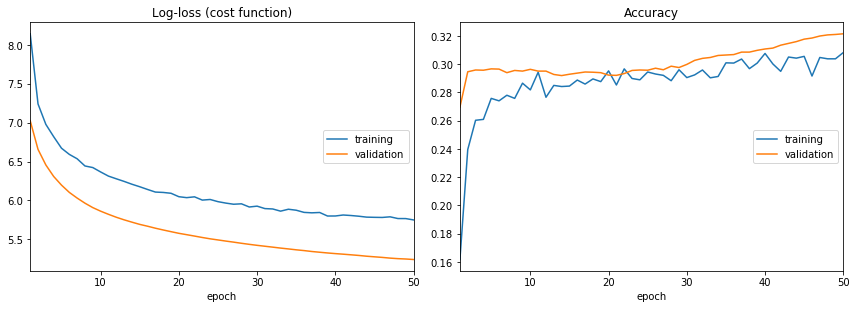

In [753]:
#Fit
model_tx.fit(X_train_tx, y_train_genres_tx, validation_data=[X_train_tx, y_train_genres_tx], 
          batch_size=64, epochs=50, verbose=2,
          callbacks=[PlotLossesKeras()])

In [754]:
Y_pred_tx = model_tx.predict_proba(X_test_tx)

In [721]:
roc_auc_score(y_test_genres_tx, Y_pred_tx, average='macro')

0.8502945377890864

### The ROC curve of the neural network implementation: 0.850294


## Fit with 200 epochs

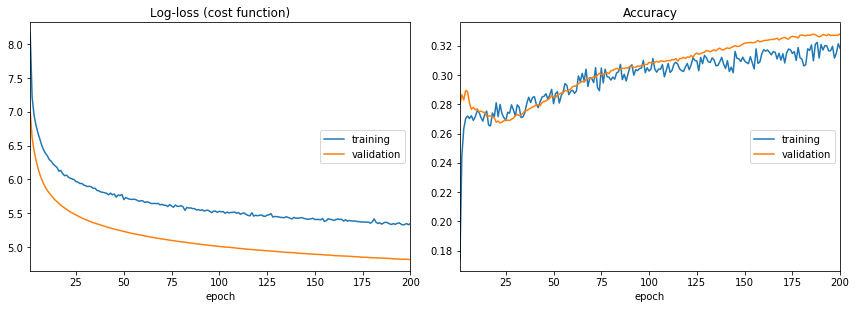

In [746]:
#Fit
model_tx.fit(X_train_tx, y_train_genres_tx, validation_data=[X_train_tx, y_train_genres_tx], 
          batch_size=64, epochs=200, verbose=2,
          callbacks=[PlotLossesKeras()])

In [747]:
#ROC
y_pred_tx = model_tx.predict_proba(X_test_tx)

In [748]:
roc_auc_score(y_test_genres_tx, y_pred_tx, average='macro')

0.840395421561472

### With the adjustment of the parameters of the optimizer Adam improves the ROC curve

In [646]:
y_pred_tx.shape, X_dtm.shape

((1579, 24), (7895, 2000))

## Kaggle

### finally we export the dataframe to load it in Kaggle

In [722]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model_tx.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_NN_5.csv', index_label='ID')

## RNN - Long short-term memory (LSTM)

## Vocabulary

In [758]:
X=dataTraining['plot'].tolist()

In [759]:
# For vocabulary only the intersec characters is used to avoid issues with data collection
voc = set(''.join(X))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

In [760]:
# Max len
max_url_len = 2000 # El 150 es el corte después de un analisis previo
X_ = [x[:max_url_len] for x in X]
# Convert characters to int and pad
X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X_]

In [761]:
X_pad = sequence.pad_sequences(X, maxlen=max_url_len)

In [762]:
X_train_r, X_test_r, y_train_genres_r, y_test_genres_r = train_test_split(X_pad, y_genres, test_size=0.2, random_state=42)

In [764]:
X_train_r.shape,  y_train_genres_r.shape, X_test_r.shape, y_test_genres_r.shape

((6316, 2000), (6316, 24), (1579, 2000), (1579, 24))

In [773]:
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_url_len))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(24, activation='sigmoid'))

model.summary()        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 128)         9600      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout_79 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_147 (Dense)            (None, 24)                792       
Total params: 31,000
Trainable params: 31,000
Non-trainable params: 0
_________________________________________________________________


In [774]:
#Compilación
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

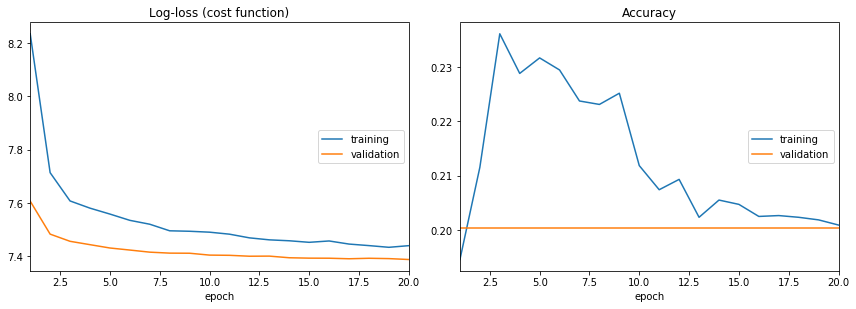

In [775]:
#Fit
model.fit(X_train_r, y_train_genres_r, validation_data=[X_train_r, y_train_genres_r], 
          batch_size=128, epochs=20, verbose=2,
          callbacks=[PlotLossesKeras()])

In [776]:
#ROC
y_pred_r = model.predict_proba(X_test_r)

In [777]:
roc_auc_score(y_test_genres_r, y_pred_r, average='macro')

0.5298785388655443

## Concatenate the results of the two neural networks

In [277]:
from keras.layers import Dense, concatenate, Input
from keras.models import Model

In [449]:
mergetOutput = Concatenate()([model_2.output, model_tx.output])

### initialization

In [452]:
out = Dense(128, activation='relu')(mergetOutput)
out = Dropout(0.8)(out)
out = Dense(24, activation='sigmoid')(out)
#out = Dense(num_classes, activation='softmax')(out)

new_model = Model(
    [model_2.input, model_tx.input], #model with two input tensors
    out                         #and one output tensor
) 

In [453]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flatten_15_input (InputLayer)   (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
dense_54_input (InputLayer)     (None, 2000)         0                                            
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 25088)        0           flatten_15_input[0][0]           
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 512)          1024512     dense_54_input[0][0]             
__________________________________________________________________________________________________
dense_20 (

## compilation

In [454]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=op_adam,
              metrics=['accuracy'])

In [ ]:
new_model.fit()

In [449]:
mergetOutput = Concatenate()([model_2.output, model_tx.output])

In [498]:
out = Dense(512, activation='relu')(mergetOutput)
out = Dropout(0.4)(out)
out = Dense(24, activation='sigmoid')(out)
#out = Dense(num_classes, activation='softmax')(out)

new_model = Model(
    [model_2.input, model_tx.input], #model with two input tensors
    out                         #and one output tensor
) 

In [499]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flatten_15_input (InputLayer)   (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
dense_54_input (InputLayer)     (None, 2000)         0                                            
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 25088)        0           flatten_15_input[0][0]           
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 512)          1024512     dense_54_input[0][0]             
__________________________________________________________________________________________________
dense_20 (

In [500]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=op_adam,
              metrics=['accuracy'])

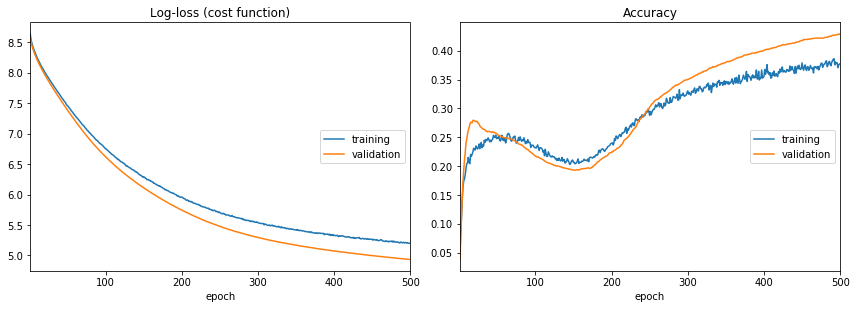

In [501]:
new_model.fit([X_train, X_train_tx], y_train_genres, batch_size=124, epochs=500, 
                     shuffle=True, verbose=2, validation_data=([X_train, X_train_tx], y_train_genres), 
                    callbacks=[PlotLossesKeras()]) 

In [502]:
#ROC
y_pred_nm = new_model.predict([ X_test, X_test_tx])

In [503]:
roc_auc_score(y_test_genres, y_pred_nm, average='macro')

0.8230937252980407

# Conclusions


We implement different algorithms (machine learning, CNN, transfer learning and RNN) with the objective of classifying a movie genre based on its plot and its poster.

The algorithm that best classifies **(Neural Network)** the genre of a movie is that of a neural network with the following architecture:
- Relu Activation
- Dropout(0.69)
- Flattern
- Dense(24, sigmoid)

- Optimized using Adam
- Loss categorical_crossentrop

The ROC curve obtained with the implementation of this algorithm is: **0.85029** 

This is the best result of the different algorithms implemented.